In [1]:
using LinearAlgebra
using DelimitedFiles
using Plots
using Random
using LinearAlgebra
using Statistics
using GZip
using DCAUtils
using StatsBase
using LaTeXStrings

In [2]:
include("../../Gen.jl/src/energy.jl");
#include("BM_utils.jl");

In [11]:
file_3TGI = "../../data_Genie/rcsb_pdb_3TGI.fasta"

"../../data_Genie/rcsb_pdb_3TGI.fasta"

In [16]:
seq_seed = read_fasta_alignment(file_3TGI, 1.0)[:];

In [18]:
#file_seq = "../../Gen.jl/data/alignments/natural/DBD_alignment.uniref90.cov80.a2m"
file_seq = "../../data_Genie/s1Ahalabi_1470_nosnakes.an"

Z_seed = read_fasta_alignment(file_seq, 1.0)
L,N_seed = size(Z_seed)
W = compute_weights(Z_seed,0.2)[1];
W ./= sum(W);
sum(W)

θ = 0.2 threshold = 166.0
M = 1390 N = 832 Meff = 462.8126974094967


1.0

In [26]:
gap = 1;
use_weights = 0;

# Protein Sectors

### Define the relative entropy

In [57]:
### Background frequencies (taken from the matlab script in the supplementary material of Halabi, Rivoire, Leibler, Ranganathan)
bg_freqs = [0.073, 0.025, 0.050, 0.061, 0.042, 0.072, 0.023, 0.053, 
0.064, 0.089, 0.023, 0.043, 0.052, 0.040, 0.052, 0.073, 0.056, 0.063, 0.013, 0.033]
@assert sum(bg_freqs) == 1

if use_weights == 1
    freqs = reshape(compute_weighted_frequencies(Z_seed,22,0.2)[1], (21,L))
else 
    freqs = reshape(compute_weighted_frequencies(Z_seed,22,0.)[1], (21,L))
end

### Adding gap frequency
if gap == 1
    ### Add weights
    γ = sum(freqs[21,:])/L
    push!(bg_freqs,γ)
    bg_freqs[1:20] .*= 1-γ
    sum(bg_freqs)
end

θ = 0.0 threshold = 0.0
M = 24944 N = 76 Meff = 24944


1.0

In [58]:
### Compute frequencies for this family and prevalent aminoacid at each position
if gap == 1
    Prevalent_amino = [argmax(freqs[:,i]) for i in 1:L] 
    Prevalent_amino_freq = [maximum(freqs[:,i]) for i in 1:L]
else
    Prevalent_amino = [argmax(freqs[1:20,i]) for i in 1:L] 
    Prevalent_amino_freq = [maximum(freqs[1:20,i]) for i in 1:L]
end

Z_seed_binarized = zeros(size(Z_seed));
for i in 1:N_seed
    Z_seed_binarized[:,i] .= (Z_seed[:,i] .== Prevalent_amino)
end

In [59]:
### Compute the quantity D and the weights ϕ
D = zeros(L)
ϕ = zeros(L)
for i in 1:L
    a = Prevalent_amino[i]
    f = Prevalent_amino_freq[i]
    bg = bg_freqs[a]
    D[i] = f * log(f/bg) + (1-f) * log((1-f)/(1-bg))
    ϕ[i] = log((f * (1-f)) / (bg * (1-bg)))
end

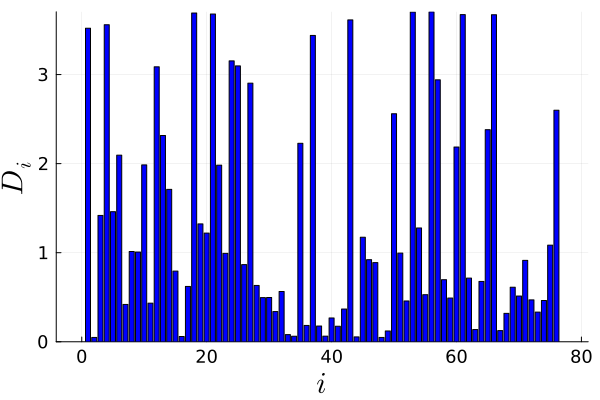

In [60]:
bar(D, color = :blue, label = "",
xtickfontsize=12,ytickfontsize=12, ztickfontsize=12,labelfontsize=20,legendfontsize=16)
plot!(xlabel=L"i")       
plot!(ylabel=L"D_i") 

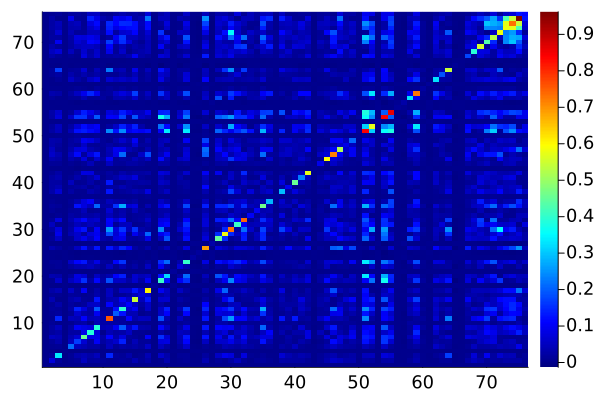

In [61]:
### Compute C_ij and the SCA version
if use_weights == 1 
    f_ij = ((Z_seed_binarized .* W') * (Z_seed_binarized)')
else
    f_ij = (Z_seed_binarized * Z_seed_binarized') ./ N_seed
end
C_ij = f_ij .- Prevalent_amino_freq * Prevalent_amino_freq'

C_sca = (ϕ * ϕ') .* abs.(C_ij)
heatmap(C_sca, color = :jet,
xtickfontsize=12,ytickfontsize=12, ztickfontsize=12,labelfontsize=20,legendfontsize=16)

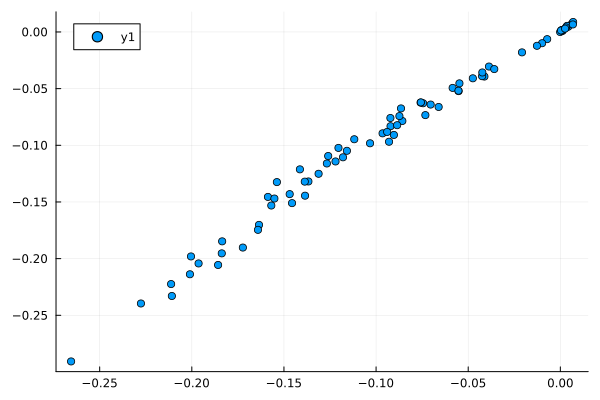

In [99]:
S_i = sum(C_sca,dims=2)[:,1] 
C_check = S_i * S_i' ./ sum(S_i)
l,v = eigen(C_check)
l[end]
scatter(v[:,end], EigenVectors[:,end])

In [62]:
### Compute eigenvalue decomposition
EigenDecomposition = eigen(C_sca)

EigenVectors = copy(EigenDecomposition.vectors)
EigenValues = copy(EigenDecomposition.values)

76-element Vector{Float64}:
 -0.08938673523787892
 -0.04281840110464027
 -0.0319869310660167
 -0.012969935896770007
 -0.011945037975965647
  1.4060361588491554e-6
  0.00048802894939178887
  0.0013967991122653262
  0.0017085783346797861
  0.0025485133594789905
  0.004657598311465214
  0.005181008955445418
  0.006008295655003118
  ⋮
  0.6274387870607652
  0.664133995047066
  0.6856125312689383
  0.7568628497320037
  0.8610266241841404
  0.886987518180046
  1.0321647230935513
  1.0865267226465074
  1.202265234306868
  1.4440631573685834
  1.836971679109948
  4.491958970643477

In [88]:
### Compute the spectrum for the randomized MSA
Nsamples = 50
EigenValues_random = []
EigenVectors_random = zeros(L,L)
for sam in 1:Nsamples
    random_MSA_bin = Array{Int,2}(undef,0,N_seed)
    for i in 1:L
        random_MSA_bin = vcat(random_MSA_bin,shuffle(Z_seed_binarized[i,:])')
    end
    f_ij_random = (random_MSA_bin * random_MSA_bin') ./ N_seed
    C_ij_random = f_ij_random .- Prevalent_amino_freq * Prevalent_amino_freq'
    C_sca_random = (ϕ * ϕ') .* abs.(C_ij_random)
    EigenDecomposition_random = eigen(C_sca_random)
    EigenValues_random = vcat(EigenValues_random,EigenDecomposition_random.values)
    EigenVectors_random += EigenDecomposition_random.vectors
end
EigenVectors_random ./= Nsamples ;

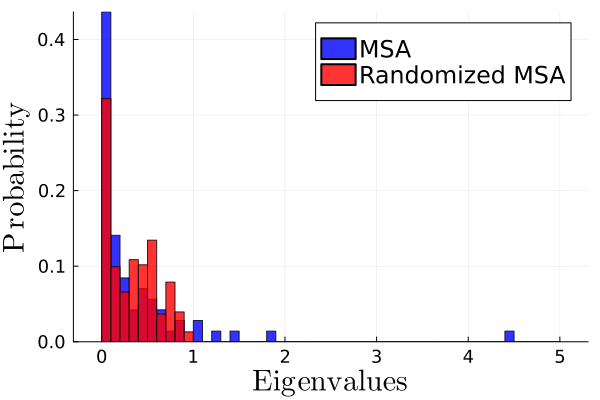

In [77]:
bins_pos = collect(0:0.1:5)
histogram(EigenValues, bins = bins_pos, normalize = :probability, color = :blue, alpha = 0.8, label = "MSA",
xtickfontsize=12,ytickfontsize=12, ztickfontsize=12,labelfontsize=20,legendfontsize=16)
histogram!(EigenValues_random, bins = bins_pos, normalize = :probability, color = :red, alpha = 0.8, label = "Randomized MSA")
plot!(xlabel=L"\textrm{Eigenvalues}")       
plot!(ylabel=L"\textrm{Probability}")

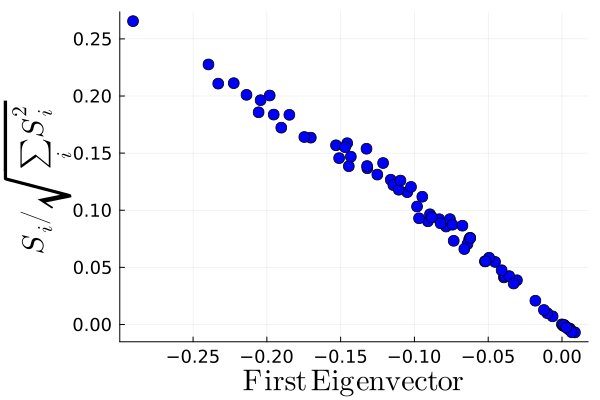

In [78]:
### Check that the first eigenvector corresponds to the first approximation of the matrix (ATTENTION, MINUS SIGN???)
scatter(EigenVectors[:,end], sum(C_sca,dims=2)[:,1] ./ sqrt(sum(sum(C_sca,dims=2)[:,1] .^ 2)), label = "", color = :blue, markersize = 6,
xtickfontsize=12,ytickfontsize=12, ztickfontsize=12,labelfontsize=20,legendfontsize=16)
plot!(xlabel=L"\textrm{First \, Eigenvector}")       
plot!(ylabel=L"S_i/\sqrt{\sum_i S_i^2}")
plot!(left_margin = 4Plots.mm)

In [79]:
cor(EigenVectors[:,end], sum(C_sca,dims=2)[:,1] ./ sqrt(sum(sum(C_sca,dims=2)[:,1] .^ 2)))

-0.9925320857255239

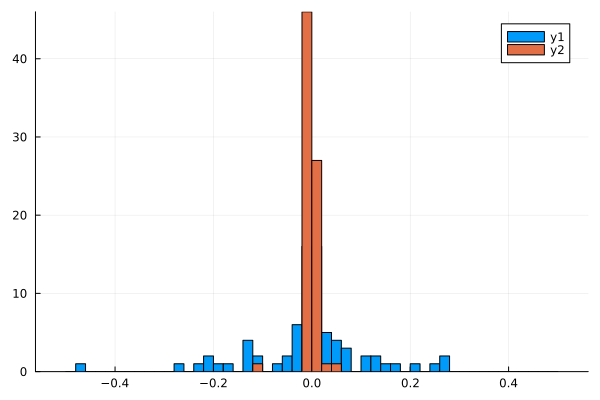

In [66]:
### Check the contributions to the second eigenvector from the standard MSA and from the randomized one
bins_pos = collect(-0.5:0.02:0.5)
histogram(EigenVectors[:,end-3], bins = bins_pos)
histogram!(EigenVectors_random[:,end-3], bins = bins_pos)

In [50]:
Sector1 = EigenVectors[:,end-2] .> 0.18
Sector2 = EigenVectors[:,end-3] .< -0.12 
Sector3 = EigenVectors[:,end-1] .> 0.2

76-element BitVector:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1

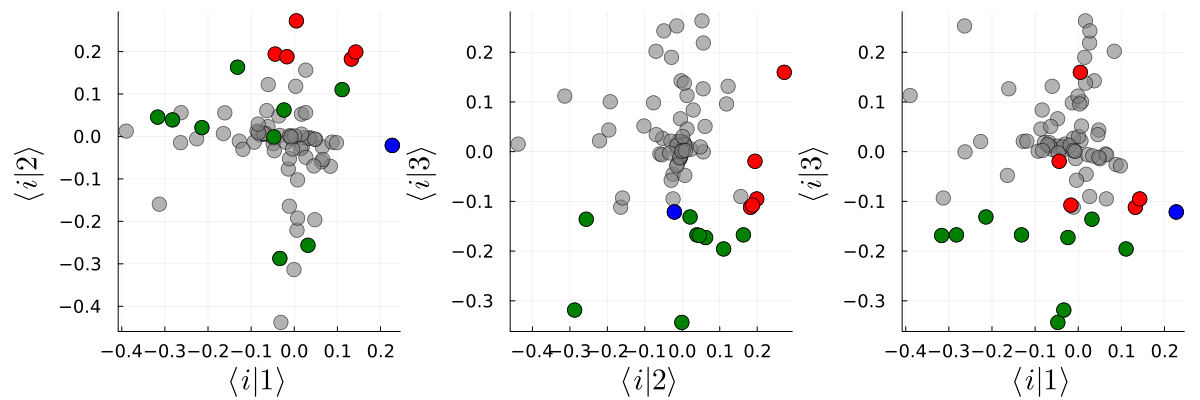

In [51]:
transp = 0.6
p1 = scatter(EigenVectors[:,end-1], EigenVectors[:,end-2], label = "", alpha = transp,
        marker = :circle, markersize = 8, color = :gray, size = (1200,400), xtickfontsize=12,ytickfontsize=12,labelfontsize=20,legendfontsize=16)
scatter!(EigenVectors[Sector1,end-1], EigenVectors[Sector1,end-2], label = "", marker = :circle, markersize = 8, color = :red)
scatter!(EigenVectors[Sector2,end-1], EigenVectors[Sector2,end-2], label = "", marker = :circle, markersize = 8, color = :green)
scatter!(EigenVectors[Sector3,end-1], EigenVectors[Sector3,end-2], label = "", marker = :circle, markersize = 8, color = :blue)
plot!(ylabel=L"\langle i | 2 \rangle")       
plot!(xlabel=L"\langle i | 1 \rangle") 
plot!(left_margin = 10Plots.mm)
p2 = scatter(EigenVectors[:,end-2], EigenVectors[:,end-3], label = "", alpha = transp,
        marker = :circle, markersize = 8, color = :gray, xtickfontsize=12,ytickfontsize=12,labelfontsize=20,legendfontsize=16)
scatter!(EigenVectors[Sector1,end-2], EigenVectors[Sector1,end-3], label = "", marker = :circle, markersize = 8, color = :red)
scatter!(EigenVectors[Sector2,end-2], EigenVectors[Sector2,end-3], label = "", marker = :circle, markersize = 8, color = :green)
scatter!(EigenVectors[Sector3,end-2], EigenVectors[Sector3,end-3], label = "", marker = :circle, markersize = 8, color = :blue)
plot!(ylabel=L"\langle i | 3 \rangle")       
plot!(xlabel=L"\langle i | 2 \rangle") 
plot!(left_margin = 5Plots.mm)
p3 = scatter(EigenVectors[:,end-1], EigenVectors[:,end-3], label = "", alpha = transp,
        marker = :circle, markersize = 8, color = :gray, xtickfontsize=12,ytickfontsize=12,labelfontsize=20,legendfontsize=16)
scatter!(EigenVectors[Sector1,end-1], EigenVectors[Sector1,end-3], label = "", marker = :circle, markersize = 8, color = :red)
scatter!(EigenVectors[Sector2,end-1], EigenVectors[Sector2,end-3], label = "", marker = :circle, markersize = 8, color = :green)
scatter!(EigenVectors[Sector3,end-1], EigenVectors[Sector3,end-3], label = "", marker = :circle, markersize = 8, color = :blue)
plot!(ylabel=L"\langle i | 3 \rangle")       
plot!(xlabel=L"\langle i | 1 \rangle") 

plot!(bottom_margin = 8Plots.mm)
plot!(right_margin = 2Plots.mm)
plot!(left_margin = 5Plots.mm)
plot(p1,p2,p3,layout = (1,3))

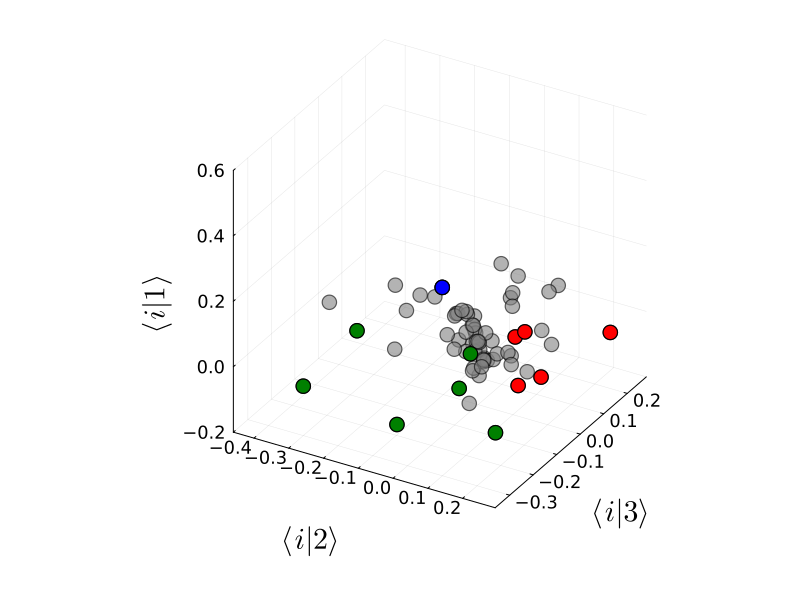

In [52]:
scatter(EigenVectors[:,end-2], EigenVectors[:,end-3], EigenVectors[:,end-1], label = "",
marker = :circle, markersize = 8, color = :gray, alpha = transp, size = (800,600), xtickfontsize=12,ytickfontsize=12, ztickfontsize=12,labelfontsize=20,legendfontsize=16)
scatter!(EigenVectors[Sector1,end-2], EigenVectors[Sector1,end-3], EigenVectors[Sector1,end-1], marker = :circle, markersize = 8, color = :red, label = "")
scatter!(EigenVectors[Sector2,end-2], EigenVectors[Sector2,end-3], EigenVectors[Sector2,end-1], marker = :circle, markersize = 8, color = :green, label = "")
scatter!(EigenVectors[Sector3,end-2], EigenVectors[Sector3,end-3], EigenVectors[Sector3,end-1], marker = :circle, markersize = 8, color = :blue, label = "")
zlims!(-0.2,0.6)
plot!(xlabel=L"\langle i | 2 \rangle")       
plot!(ylabel=L"\langle i | 3 \rangle") 
plot!(zlabel=L"\langle i | 1 \rangle") 
plot!(bottom_margin = 1Plots.mm)
plot!(right_margin = 1Plots.mm)
plot!(left_margin = 1Plots.mm)

In [53]:
C_clean = zeros(L,L)
for k in 1:3
    C_clean = C_clean + EigenValues[end-k] .* (EigenVectors[:,end-k] * EigenVectors[:,end-k]')
end

In [54]:
V1 = sortperm(EigenVectors[:,end-2],rev=true)[1:sum(Sector1)]
V2 = sortperm(EigenVectors[:,end-3])[1:sum(Sector2)]
V3 = sortperm(EigenVectors[:,end-1],rev=true)[1:sum(Sector3)]

V = vcat(V1,V2,V3)
println("Sites in sector 1: $V1")
println("Sites in sector 2: $V2")
println("Sites in sector 3: $V3")

Sites in sector 1: [51, 35, 29, 70, 13]
Sites in sector 2: [15, 45, 12, 62, 74, 73, 14, 64, 72, 76]
Sites in sector 3: [76]


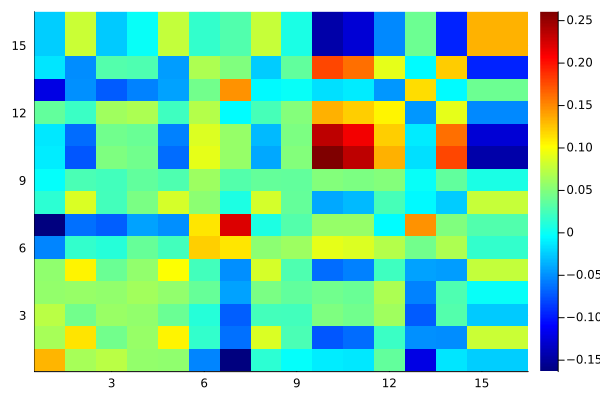

In [55]:
heatmap(C_clean[V,V], color = :jet)

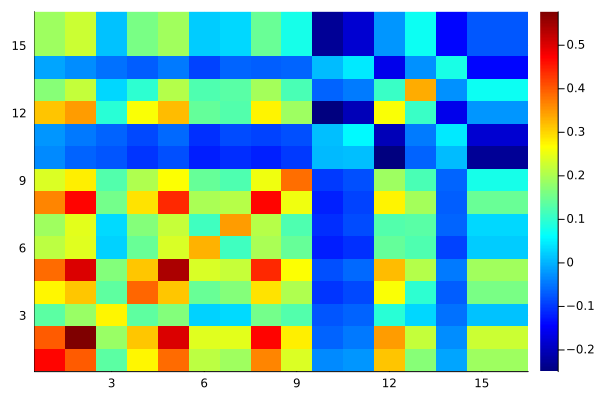

In [56]:
heatmap(C_ij[V,V], color = :jet)